# __Impact of Release Month on Indie Games(PC)__
#### Noah Eddleman


### __Introduction to the Problem__
The creation of a video game is a massive undertaking. Even moreso when the development team consists of few members. The last thing a team wants to do is create a great game and release at the wrong time. While there are many factors relating to the success of a video game, 
i.e. marketing, overall funding. The time of release also plays a role in its exposure to consumers.

### __The Data__
The dataset was obtained on Kaggle from the following link:
https://www.kaggle.com/datasets/artermiloff/steam-games-dataset?select=games_may2024_cleaned.csv

It contains a recently updated database of video games on the PC platform Steam. The data was already cleaned of duplicates and playtest/beta versions of games.

Note:
This data does not contain any sales information and all conclusions are drawn based on overall receptiveness towards the games. In addition, this data only accounts for games sold on the platform Steam, and not other online retail platforms, or games sold for consoles.

In [4]:
# Relevant imports
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

In [5]:
steam_df: pd.DataFrame = pd.read_csv('games_may2024_cleaned.csv')

### __Pre-Processing the Data__
As we are trying to determine the impact of release date on an Indie Game, it is necessary to first clarify what defines an Indie Game.
An Indie Game is generally accepted to be a video game "created by individuals or smaller development teams without the support of a large game publisher ("Indie Game", 2024)." While there are many different aspects that other may consider more important, for our purposes, the separation of Indie Game versus Triple-A game will be determined based off this definition.

##### What about AA games?
AA games, or Double-A games, are games that tend to fall in-between the two extremes. They might recieve a level of funding and the support of a smaller publisher, but retain significant control over the game itself. Many games that are widely considered Indie game titles, are actually AA. For the purpose of this project, AA games will be considered as Indie games, as they tend to still follow the core definition.


##### Steps
To determine if a game is indie or not I first pondered the idea of a price threshold, where Indie games tend to release at or under 35(USD). The main problem with this quickly became apparent, as we are looking at an online retail platform, the discounting of older AAA games is extremely common. Any given title released in the past 10-15 years is likely being sold at a 80%+ discount from its release price. Becuase of this, without extra data regarding price history, this method was swiftly tossed. Instead, composing a list of well known AAA publishers from the data, and using this as our check. If the publisher of any game resides in the list, it is likely not an Indie Game.

In [6]:
# Extract release data into separate columns, as well as convert release_date into a DateTime object
steam_df['release_year'] = steam_df['release_date'].apply(lambda y: int((str(y).split('-'))[0]))
steam_df['release_month'] = steam_df['release_date'].apply(lambda m: int((str(m).split('-'))[1]))
steam_df['release_day'] = steam_df['release_date'].apply(lambda d: int((str(d).split('-'))[2]))
steam_df['release_date'] = pd.to_datetime(steam_df['release_date'], format='%Y-%m-%d')

# Get current age of game
steam_df["current_age"] = dt.datetime.now() - steam_df['release_date']

## List of well known AAA publishers/developers within the data
# Note: These were just taken from the data with my knowledge of AAA studios. 
#       There are a number of foreign publishers that I do not know are indie or not.
AAA_list = ['VALVE', 'Valve' ,'CD PROJEKT RED',
    'FromSoftware Inc.', 'FromSoftware', 'Bandai Namco Entertainment', 'Rockstar Games', 'Xbox Game Studios',
    'Electronic Arts', 'EA', 'Warner Bros. Games', '2K', 'Bethesda Softworks', 'Larian Studios', 'Ubisoft', 'CAPCOM Co. Ltd.',
    'PlayStation PC LLC', 'CAPCOM Co.', 'SEGA', 'Warner Bros. Interactive Entertainment', 'Paradox Interactive', 'Square Enix',
    'KONAMI', 'Capcom', 'BANDAI NAMCO Entertainment', 'Lucasfilm', 'LucasArts', 'Disney', 'Activision', 'Focus Entertainement', 'Bungie',
    'Activision (Excluding Japan and Asia)', 'FromSoftware (Japan)', 'bandai namco entertainment inc.'
]


# adjusting string data
adjusted_publishers = []
for p in steam_df['publishers']:
    for c in "'[]":
        p = p.replace(c, '').lower()
    adjusted_publishers.append(p)

steam_df['publishers'] = adjusted_publishers

# adjusting string data
adjusted_AAA_list = [s.lower() for s in AAA_list]


# add games with publishers not in the AAA list
probably_indie = []

for p in adjusted_publishers:
    if p not in adjusted_AAA_list:
        probably_indie.append(p)

# If the publisher is in the indie list, set true
steam_df['is_indie'] = steam_df['publishers'].isin(probably_indie)

In addition to the main boolean sorting of whether or not a game is Indie, a series of other checks were performed to ensure a released game at one point had a player base. Steam is notorious for poorly released, asset flip titles that dilute the data of true releases. To account for this, I first initially check that the peak concurrent player count (the max number of players at any given time since release), is greater than or equal to 100. While 100 may seem low, we must keep in mind that many Indie games can still be considered successful with lower player counts. A game with around 100 max ccu, is likely a lower cost, 5(USD) game made by an individual without significant marketing.

Using the ratio of positive reviews to negative reviews also gives some insight into the success of a game. A well received game will have a much better ratio than a poorly receieved game. After creating the ratio column, I then sort the ratio's to find the median ratio of the remaining games. This is the final cut in the pre-processing stage. Altering the dataframe to contain only games that are between the median_ratio - 2.0 and the arbitrary value of 60.0.

Note:
The ratio represents the number of times greater the positive ratings than the negative ratings. So a game with a ratio of 6.0, has 6.0 times as many positive ratings than negative ratings. There were a few outliers with ratios in the 100-200 range, because of how ratio is calculated, its completely possible that these are games with a low review count in general, ie. 140 positive ratings, 1 negative rating, which is something only experienced by Indie releases on Steam. The number of these games was low enough that the 60.0 threshold still retains an accurate representation of the data.

In [7]:
# Filter by peak player count to remove games that release below player threshold
steam_df = steam_df[steam_df['peak_ccu'] >= 100]

# Get ratio of positive ratings to negative ratings...making sure we don't divide by zero
steam_df['ratio'] = steam_df['positive'] / steam_df['negative'].replace(0, np.nan)

# Sort the games based on their ratio
games_sorted_by_ratio = steam_df.sort_values(by='ratio', ascending=False)
median_index = int(len(games_sorted_by_ratio) / 2.0)
median_game = games_sorted_by_ratio.iloc[median_index]

# Get median ratio value 
median_ratio = median_game['ratio']
 
# Only use games that have greater than 50 recommendations
steam_df = steam_df[steam_df['recommendations'] > 50]

# Remove major outliers from median playtime forever
steam_df = steam_df[(steam_df['median_playtime_forever'] < 1_000)]

# Remove major outliers from average playtime forever
steam_df = steam_df[(steam_df['average_playtime_forever'] < 3_000)]

# Get ratios from median to 60.0(upper limit)
steam_df = steam_df[(steam_df['ratio'] >= median_ratio - 2.0) & (steam_df['ratio'] <= 60.0)]

# Overall number of indie games
num_indie_games = len(steam_df[steam_df['is_indie'] == True])
num_AAA_games = len(steam_df[steam_df['is_indie'] == False])
indie_to_AAA_ratio = num_indie_games / num_AAA_games

print(indie_to_AAA_ratio)

3.9368421052631577


Now that we have data consisting of well receieved games, we can create some visualizations to help examine our results.

##### Figure 1.
The first figure shows the volume of games released on average each month. We can see that the number of Indie Games vastly outnumbers the number of AAA games. This is to be expected, as the development time and cost of Indie Games varies greatly, they can be released at a greater pace. The figure shows that the number of Indie Games released tends to peak from March-May, and again in August and September. AAA games seem to have 3 main release months: March, June, and November. 

##### Figure 2.
The second figure shows the volume of releases by year. This figure paints a very clear picture of the sheer volume of Indie Games that release starting around 2015. While the number of AAA has increased over time, it has remained relatively stable.

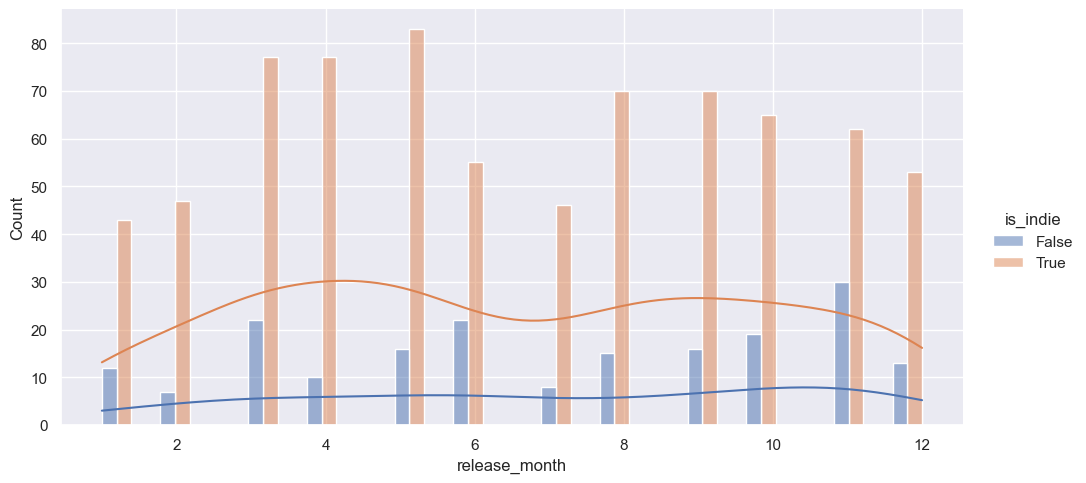

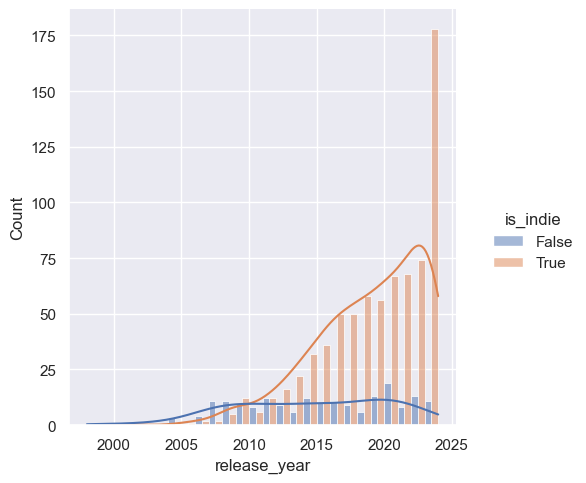

In [37]:
sns.displot(data=steam_df, x="release_month", hue='is_indie', multiple='dodge', binwidth=0.4, aspect=2.0, kde=True)
sns.displot(data=steam_df, x="release_year", hue='is_indie', multiple='dodge', binwidth=1.0, aspect=1.0, kde=True)

##### Figure 3.
This figure 

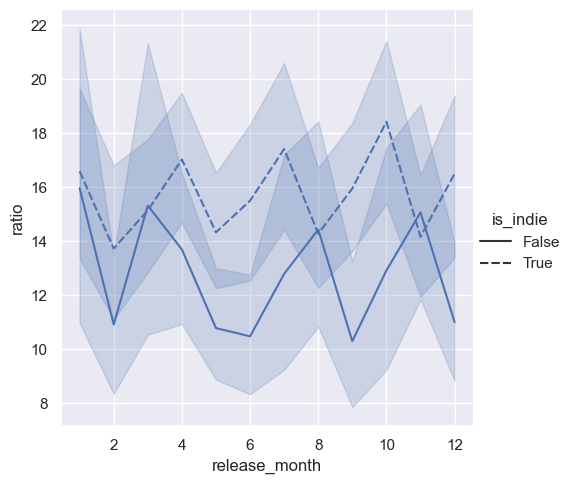

In [59]:

sns.set(rc={"figure.figsize":(20,12)}) 
g = sns.relplot(
    data=steam_df, kind='line', hue='is_indie',
    x='release_month', y='ratio', style='is_indie'
)

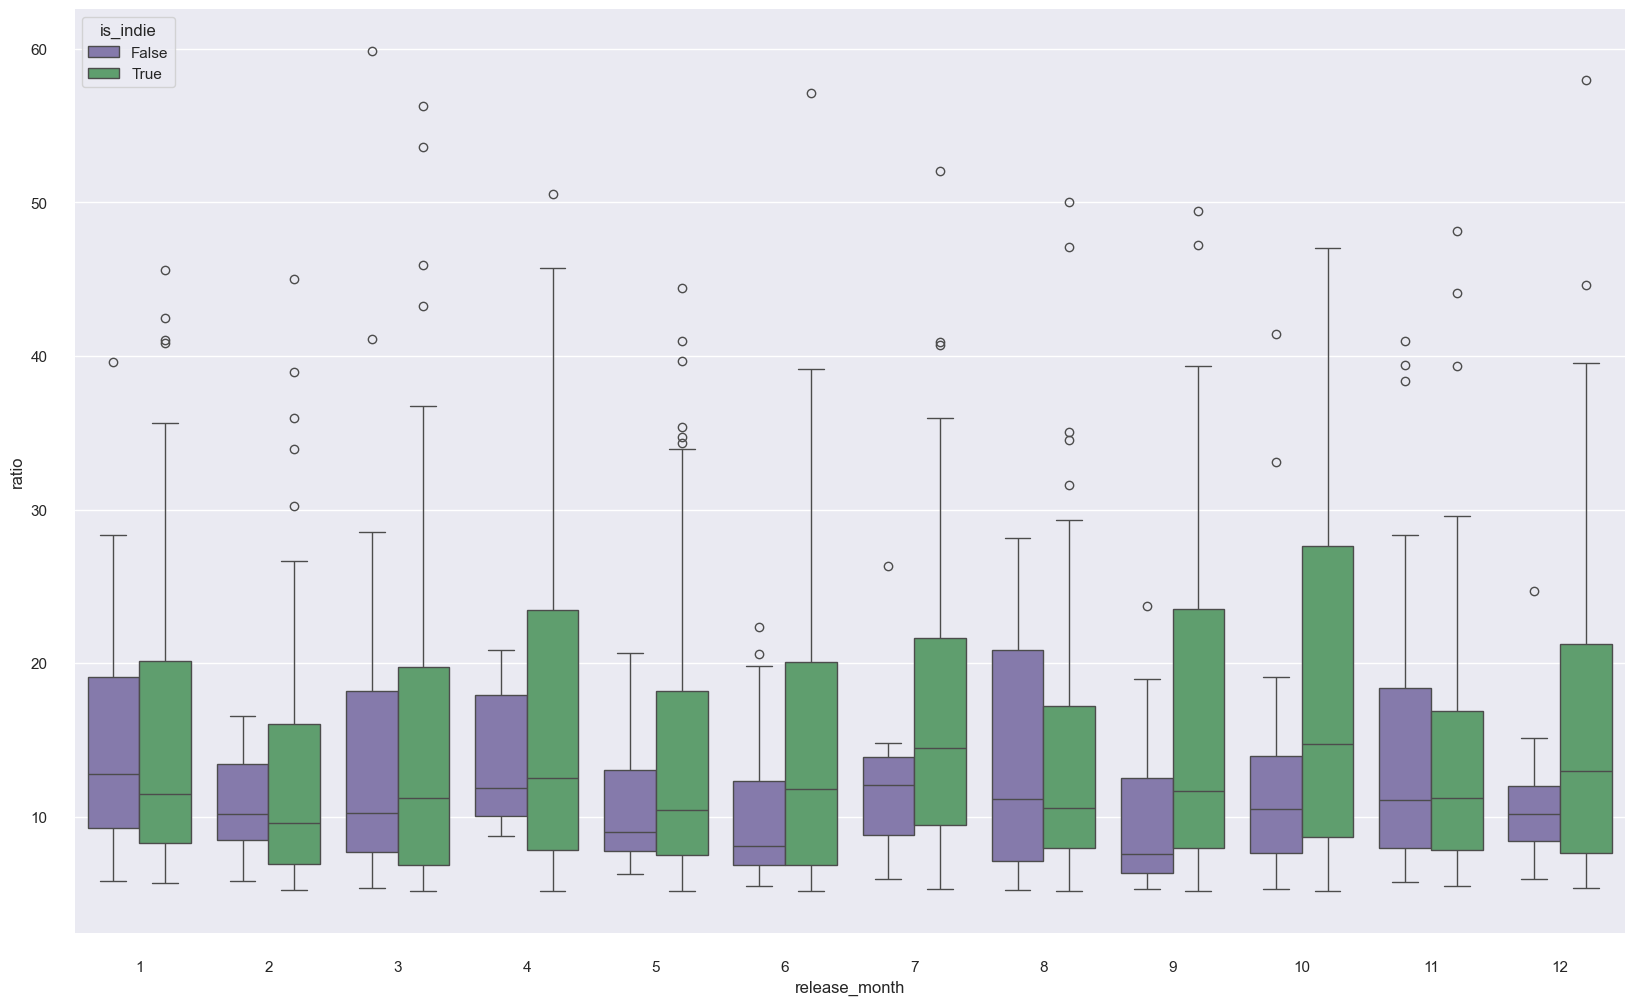

In [35]:

sns.boxplot(x="release_month", y="ratio",
            hue="is_indie", palette=["m", "g"],
            data=steam_df)
sns.despine(offset=10, trim=True)

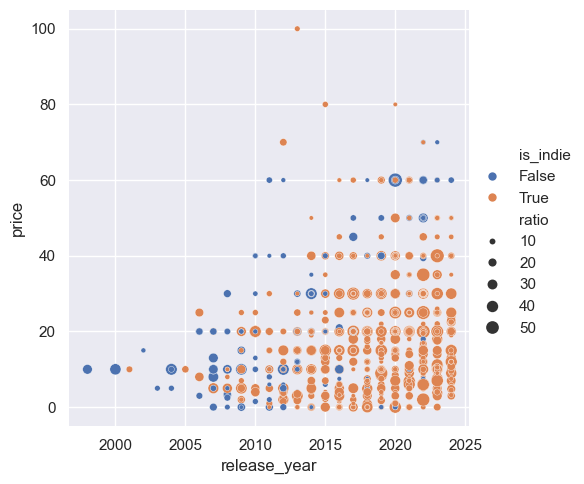

In [36]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=steam_df,
    x="release_year", y="price",
    hue="is_indie", size="ratio", 
    sizes=(10, 100),
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

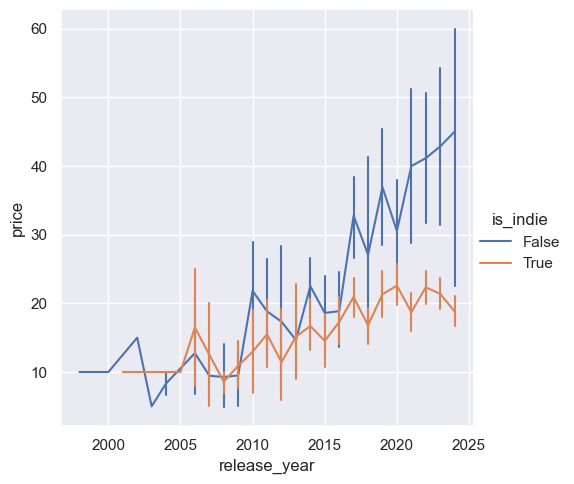

In [37]:
sns.relplot(x='release_year', y='price', data=steam_df, kind="line", hue='is_indie', errorbar=('ci', 90), err_style='bars')